In [26]:
from models import *
from utils import  *
import torch
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
from tqdm import tqdm

In [27]:
EPOCHS = 30

In [28]:
teacher_model_vgg16_bn = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar100_vgg16_bn", pretrained=True)
device = 'cuda'if torch.cuda.is_available() else 'cpu'
print(eval(teacher_model_vgg16_bn.to(device),train_loader,nn.CrossEntropyLoss(),'cuda'))
print(eval(teacher_model_vgg16_bn.to(device),test_loader,nn.CrossEntropyLoss(),'cuda'))

Using cache found in C:\Users\PCF/.cache\torch\hub\chenyaofo_pytorch-cifar-models_master


(0.01765723146371367, array(0.99543995, dtype=float32))
(2.066835571246542, array(0.69159997, dtype=float32))


In [29]:
teacher_model_vgg19_bn = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar100_vgg19_bn", pretrained=True)
device = 'cuda'if torch.cuda.is_available() else 'cpu'
print(eval(teacher_model_vgg19_bn.to(device),train_loader,nn.CrossEntropyLoss(),'cuda'))
print(eval(teacher_model_vgg19_bn.to(device),test_loader,nn.CrossEntropyLoss(),'cuda'))

Using cache found in C:\Users\PCF/.cache\torch\hub\chenyaofo_pytorch-cifar-models_master


(0.017511192039745, array(0.99552, dtype=float32))
(2.247335283619583, array(0.6947, dtype=float32))


In [30]:
def train_lm(student_model,teacher_model,train_loader,optimizer,device,types="basic",f=False):
    '''
    Carries out one epoch of training through logit matching
    '''
    total_loss = 0
    pred_list = None
    for params in teacher_model.parameters():
        params.requires_grad = False
    for i,batch in enumerate(train_loader):
        x_batch, y_batch = batch
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        if types == "basic":
            loss,preds = basic_logic_matching(student_model,teacher_model,x_batch,y_batch,optimizer,device,f=f)
        elif types == "lsr":
            loss,preds = lsr_logit_matching(student_model,teacher_model,x_batch,y_batch,optimizer,device,f=f)
        elif types == "dkd":
            loss,preds = decoupled_logit_matching(student_model,teacher_model,x_batch,y_batch,optimizer,device,f=f)

        total_loss += loss
        pred_list = torch.cat([pred_list,preds]) if pred_list is not None else preds

    total_loss /= len(train_loader)

    return total_loss,pred_list.float().mean().cpu().numpy()

#### 3.1.2.1: Basic Logit Matching with VGG 16 Teacher

In [31]:
student_model = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar100_vgg11_bn", pretrained=False)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
for param in student_model.parameters():
    param.requires_grad = True          
for param in teacher_model_vgg16_bn.parameters():
    param.requires_grad = False
teacher_model = teacher_model_vgg16_bn.to(device)
student_model = student_model.to(device)
optimizer = torch.optim.Adam(student_model.parameters(),lr=0.002)
loss_func = torch.nn.CrossEntropyLoss()
tr_metric = {"Accuracy":[],"Loss":[]}
ts_metric = {"Accuracy":[],"Loss":[]}

for epoch in (range(EPOCHS)):
    tr_loss, tr_acc = train_lm(student_model,teacher_model,train_loader,optimizer,device)
    tr_metric["Accuracy"].append(tr_acc)
    tr_metric["Loss"].append(tr_loss)

    print("Epoch: {} Train Loss: {:.2f} Train Accuracy: {:.2f}".format(epoch+1, tr_loss, tr_acc))
ts_loss, ts_acc = eval(student_model,test_loader,loss_func,device)
ts_metric["Accuracy"].append(ts_acc)
ts_metric["Loss"].append(ts_loss)
print("Epoch: {} Train Loss: {:.2f} Train Accuracy: {:.2f} Test Loss: {:.2f} Test Accuracy: {:.2f}".format(epoch+1, tr_loss, tr_acc, ts_loss, ts_acc))


Using cache found in C:\Users\PCF/.cache\torch\hub\chenyaofo_pytorch-cifar-models_master


Epoch: 1 Train Loss: 11.99 Train Accuracy: 0.03
Epoch: 2 Train Loss: 11.43 Train Accuracy: 0.04
Epoch: 3 Train Loss: 11.13 Train Accuracy: 0.05
Epoch: 4 Train Loss: 10.85 Train Accuracy: 0.06
Epoch: 5 Train Loss: 10.65 Train Accuracy: 0.07
Epoch: 6 Train Loss: 10.39 Train Accuracy: 0.09
Epoch: 7 Train Loss: 10.12 Train Accuracy: 0.10
Epoch: 8 Train Loss: 9.83 Train Accuracy: 0.11
Epoch: 9 Train Loss: 9.59 Train Accuracy: 0.13
Epoch: 10 Train Loss: 9.35 Train Accuracy: 0.14
Epoch: 11 Train Loss: 9.10 Train Accuracy: 0.16
Epoch: 12 Train Loss: 8.86 Train Accuracy: 0.17
Epoch: 13 Train Loss: 8.63 Train Accuracy: 0.19
Epoch: 14 Train Loss: 8.43 Train Accuracy: 0.21
Epoch: 15 Train Loss: 8.24 Train Accuracy: 0.22
Epoch: 16 Train Loss: 8.07 Train Accuracy: 0.23
Epoch: 17 Train Loss: 7.89 Train Accuracy: 0.25
Epoch: 18 Train Loss: 7.76 Train Accuracy: 0.26
Epoch: 19 Train Loss: 7.58 Train Accuracy: 0.27
Epoch: 20 Train Loss: 7.40 Train Accuracy: 0.29
Epoch: 21 Train Loss: 7.25 Train Accuracy:

In [32]:
print("Final Train Accuracy:",tr_metric["Accuracy"][-1])
print("Final Test Accuracy:",ts_metric["Accuracy"][-1])
print("Final Train Loss:",tr_metric["Loss"][-1])
print("Final Test Loss:",ts_metric["Loss"][-1])

Final Train Accuracy: 0.4251
Final Test Accuracy: 0.38799998
Final Train Loss: 6.066527304442032
Final Test Loss: 2.7611208835225196


In [33]:
pd.DataFrame(tr_metric).to_csv("vgg11_cifar100_blm_6_tr.csv") 
pd.DataFrame(ts_metric).to_csv("vgg11_cifar100_blm_6_ts.csv")

In [34]:
torch.save(student_model.state_dict(),"vgg11_cifar100_blm_6.pth")

#### 3.6: Basic Logit Matching with VGG 19 Teacher

In [35]:
student_model = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar100_vgg11_bn", pretrained=False)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
for param in student_model.parameters():
    param.requires_grad = True          
for param in teacher_model_vgg19_bn.parameters():
    param.requires_grad = False
teacher_model = teacher_model_vgg19_bn.to(device)
student_model = student_model.to(device)
optimizer = torch.optim.Adam(student_model.parameters(),lr=0.002)
loss_func = torch.nn.CrossEntropyLoss()
tr_metric = {"Accuracy":[],"Loss":[]}
ts_metric = {"Accuracy":[],"Loss":[]}

for epoch in (range(EPOCHS)):
    tr_loss, tr_acc = train_lm(student_model,teacher_model,train_loader,optimizer,device)
    tr_metric["Accuracy"].append(tr_acc)
    tr_metric["Loss"].append(tr_loss)

    print("Epoch: {} Train Loss: {:.2f} Train Accuracy: {:.2f}".format(epoch+1, tr_loss, tr_acc))
ts_loss, ts_acc = eval(student_model,test_loader,loss_func,device)
ts_metric["Accuracy"].append(ts_acc)
ts_metric["Loss"].append(ts_loss)
print("Epoch: {} Train Loss: {:.2f} Train Accuracy: {:.2f} Test Loss: {:.2f} Test Accuracy: {:.2f}".format(epoch+1, tr_loss, tr_acc, ts_loss, ts_acc))


Using cache found in C:\Users\PCF/.cache\torch\hub\chenyaofo_pytorch-cifar-models_master


Epoch: 1 Train Loss: 12.09 Train Accuracy: 0.02
Epoch: 2 Train Loss: 11.70 Train Accuracy: 0.03
Epoch: 3 Train Loss: 11.49 Train Accuracy: 0.04
Epoch: 4 Train Loss: 11.29 Train Accuracy: 0.05
Epoch: 5 Train Loss: 11.01 Train Accuracy: 0.06
Epoch: 6 Train Loss: 10.60 Train Accuracy: 0.07
Epoch: 7 Train Loss: 10.24 Train Accuracy: 0.09
Epoch: 8 Train Loss: 9.92 Train Accuracy: 0.11
Epoch: 9 Train Loss: 9.64 Train Accuracy: 0.12
Epoch: 10 Train Loss: 9.35 Train Accuracy: 0.14
Epoch: 11 Train Loss: 9.08 Train Accuracy: 0.15
Epoch: 12 Train Loss: 8.82 Train Accuracy: 0.17
Epoch: 13 Train Loss: 8.57 Train Accuracy: 0.19
Epoch: 14 Train Loss: 8.35 Train Accuracy: 0.21
Epoch: 15 Train Loss: 8.17 Train Accuracy: 0.23
Epoch: 16 Train Loss: 7.95 Train Accuracy: 0.25
Epoch: 17 Train Loss: 7.78 Train Accuracy: 0.26
Epoch: 18 Train Loss: 7.63 Train Accuracy: 0.28
Epoch: 19 Train Loss: 7.49 Train Accuracy: 0.29
Epoch: 20 Train Loss: 7.33 Train Accuracy: 0.30
Epoch: 21 Train Loss: 7.19 Train Accuracy:

In [36]:
print("Final Train Accuracy:",tr_metric["Accuracy"][-1])
print("Final Test Accuracy:",ts_metric["Accuracy"][-1])
print("Final Train Loss:",tr_metric["Loss"][-1])
print("Final Test Loss:",ts_metric["Loss"][-1])

Final Train Accuracy: 0.43339998
Final Test Accuracy: 0.3947
Final Train Loss: 5.957673628921704
Final Test Loss: 2.7184100971100436


In [37]:
pd.DataFrame(tr_metric).to_csv("vgg11_cifar100_blm_tr_vgg19.csv") 
pd.DataFrame(ts_metric).to_csv("vgg11_cifar100_blm_ts_vgg19.csv")

In [38]:
torch.save(student_model.state_dict(),"vgg11_cifar100_blm_vgg19.pth")

Further evaluation (F1 Score, Allignment of Predictions, GradCAM Similarities)

In [39]:
import torch
from sklearn.metrics import f1_score, accuracy_score

def eval_f1_acc(model,test_loader,device):
    # Initialize lists to store true and predicted labels
    all_preds = []
    all_labels = []

    # Put model in evaluation mode
    model.eval()

    with torch.no_grad():  # Disable gradient computation for efficiency
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move to GPU if available
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)  # Get the predicted class
            
            # Collect predictions and true labels
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate Accuracy
    accuracy = accuracy_score(all_labels, all_preds)

    # Calculate F1 Scores
    f1_micro = f1_score(all_labels, all_preds, average='micro')
    f1_macro = f1_score(all_labels, all_preds, average='macro')
    f1_weighted = f1_score(all_labels, all_preds, average='weighted')

    # Display results
    print("Accuracy:", accuracy)
    print("Micro F1 Score:", f1_micro)
    print("Macro F1 Score:", f1_macro)
    print("Weighted F1 Score:", f1_weighted)

print("Student Model (VGG16 teacher -> VGG11 student)")
student_model = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar100_vgg11_bn", pretrained=False).to(device)
student_model.load_state_dict(torch.load("vgg11_cifar100_blm_6.pth"))
eval_f1_acc(student_model,test_loader,device)
print("Student Model (VGG19 teacher -> VGG11 student)")
student_model = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar100_vgg11_bn", pretrained=False).to(device)
student_model.load_state_dict(torch.load("vgg11_cifar100_blm_vgg19.pth"))
eval_f1_acc(student_model,test_loader,device)

Student Model (VGG16 teacher -> VGG11 student)


Using cache found in C:\Users\PCF/.cache\torch\hub\chenyaofo_pytorch-cifar-models_master


Accuracy: 0.4237
Micro F1 Score: 0.4237
Macro F1 Score: 0.41740831851047155
Weighted F1 Score: 0.4174083185104715
Student Model (VGG19 teacher -> VGG11 student)


Using cache found in C:\Users\PCF/.cache\torch\hub\chenyaofo_pytorch-cifar-models_master


Accuracy: 0.4303
Micro F1 Score: 0.4303
Macro F1 Score: 0.422057113980514
Weighted F1 Score: 0.4220571139805141


In [40]:
def evaluate_similarities(teacher, student, test_loader):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    student = student.to(device)
    teacher = teacher.to(device)
    sim_kl = 0
    sim_wassertein = 0 
    sim_dks = 0
    sim_src = 0
    for batch_x, batch_y in test_loader:
        batch_x = batch_x.to(device)
        student_feats = student(batch_x)
        teacher_feats = teacher(batch_x)
        student_probs = F.softmax(student_feats,dim=-1) 
        teacher_probs = F.softmax(teacher_feats,dim=-1)
        sim_kl += kl_divergence(teacher_probs,student_probs)
        sim_wassertein += wasserstein_distance_batch(teacher_probs,student_probs)
        sim_dks += ks_test(teacher_probs,student_probs)
        sim_src += spearman_rank_corr(teacher_probs,student_probs)
    
    n = len(test_loader)
    print("For the following metrics, the lower the value the better the similarity between the student and teacher model.")
    print("KL Divergence:")
    print(sim_kl/n)
    print("Two Sample KS Test:")
    print(sim_dks/n)
    print("Wasserstein Distance:")
    print(sim_wassertein/n)
    print("For the following metrics, the higher the value the better the similarity between the student and teacher model.")
    print("Spearmans Rank Correlation:")
    print(sim_src/n)


print("Student Model (VGG16 teacher -> VGG11 student)")
student_model = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar100_vgg11_bn", pretrained=False).to(device)
student_model.load_state_dict(torch.load("vgg11_cifar100_blm_6.pth"))
for params in student_model.parameters():
    params.requires_grad = False
for params in teacher_model_vgg16_bn.parameters():
    params.requires_grad = False
evaluate_similarities(teacher_model_vgg16_bn,student_model,test_loader)
print("Student Model (VGG19 teacher -> VGG11 student)")
student_model = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar100_vgg11_bn", pretrained=False).to(device)
student_model.load_state_dict(torch.load("vgg11_cifar100_blm_vgg19.pth"))
for params in student_model.parameters():
    params.requires_grad = False
for params in teacher_model_vgg19_bn.parameters():
    params.requires_grad = False
evaluate_similarities(teacher_model_vgg19_bn,student_model,test_loader)

Student Model (VGG16 teacher -> VGG11 student)


Using cache found in C:\Users\PCF/.cache\torch\hub\chenyaofo_pytorch-cifar-models_master


For the following metrics, the lower the value the better the similarity between the student and teacher model.
KL Divergence:
0.004825056618032087
Two Sample KS Test:
0.5143550955414014
Wasserstein Distance:
0.007713717927073184
For the following metrics, the higher the value the better the similarity between the student and teacher model.
Spearmans Rank Correlation:
0.44660547583420773
Student Model (VGG19 teacher -> VGG11 student)


Using cache found in C:\Users\PCF/.cache\torch\hub\chenyaofo_pytorch-cifar-models_master


For the following metrics, the lower the value the better the similarity between the student and teacher model.
KL Divergence:
0.004921190323497934
Two Sample KS Test:
0.4971238057324841
Wasserstein Distance:
0.007591237348958416
For the following metrics, the higher the value the better the similarity between the student and teacher model.
Spearmans Rank Correlation:
0.5158088352625072


In [41]:
import torch
import numpy as np
import cv2
from torchvision import models, transforms
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

In [42]:
for params in teacher_model_vgg16_bn.parameters():
    params.requires_grad = True
teacher_model_vgg16_bn.eval()
from matplotlib import pyplot as plt

# Preprocess the input image
test = CIFAR100(root='./data', train=False, download=True)
idx = [11,12,13,14,16,25,28,36,37,45,58,73,83,96,98,109,120,122,138,141,147,150,160,162,166,170,179,183,201,132]
t_16_result = []
for i in idx:
    image = test[i][0]
    label = test[i][1]
    original_image = np.array(image)
    original_image = np.float32(original_image) / 255
    rgb_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

    input_tensor = transform_test(rgb_image).unsqueeze(0)  # Add batch dimension

    # Choose the target class label
    target_label = label  # Replace with desired class index
    targets = [ClassifierOutputTarget(target_label)]
    target_layer = [teacher_model_vgg16_bn.features[-2]]

    # Initialize Grad-CAM with the model and target layer
    cam = GradCAM(model=teacher_model_vgg16_bn, target_layers=target_layer)

    # Generate the Grad-CAM heatmap
    grayscale_cams = cam(input_tensor=input_tensor, targets=targets)
    cam_image = show_cam_on_image(original_image, grayscale_cams[0, :], use_rgb=True)  # First image in batch
    cam = np.uint8(255*grayscale_cams[0, :])
    cam = cv2.merge([cam, cam, cam])
    images = np.hstack((np.uint8(255*rgb_image), cam , cam_image))
    Image.fromarray(images)
    t_16_result.append(images)

Files already downloaded and verified


In [43]:
for params in teacher_model_vgg19_bn.parameters():
    params.requires_grad = True
teacher_model_vgg19_bn.eval()
from matplotlib import pyplot as plt

# Preprocess the input image
test = CIFAR100(root='./data', train=False, download=True)
idx = [11,12,13,14,16,25,28,36,37,45,58,73,83,96,98,109,120,122,138,141,147,150,160,162,166,170,179,183,201,132]
t_19_result = []
for i in idx:
    image = test[i][0]
    label = test[i][1]
    original_image = np.array(image)
    original_image = np.float32(original_image) / 255
    rgb_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

    input_tensor = transform_test(rgb_image).unsqueeze(0)  # Add batch dimension

    # Choose the target class label
    target_label = label  # Replace with desired class index
    targets = [ClassifierOutputTarget(target_label)]
    target_layer = [teacher_model_vgg19_bn.features[-2]]

    # Initialize Grad-CAM with the model and target layer
    cam = GradCAM(model=teacher_model_vgg19_bn, target_layers=target_layer)

    # Generate the Grad-CAM heatmap
    grayscale_cams = cam(input_tensor=input_tensor, targets=targets)
    cam_image = show_cam_on_image(original_image, grayscale_cams[0, :], use_rgb=True)  # First image in batch
    cam = np.uint8(255*grayscale_cams[0, :])
    cam = cv2.merge([cam, cam, cam])
    images = np.hstack((np.uint8(255*rgb_image), cam , cam_image))
    Image.fromarray(images)
    t_19_result.append(images)

Files already downloaded and verified


In [44]:
student_model = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar100_vgg11_bn", pretrained=False).to(device)
student_model.load_state_dict(torch.load("vgg11_cifar100_blm_vgg19.pth"))
student_model.eval()
from matplotlib import pyplot as plt

# Preprocess the input image
test = CIFAR100(root='./data', train=False, download=True)
idx = [11,12,13,14,16,25,28,36,37,45,58,73,83,96,98,109,120,122,138,141,147,150,160,162,166,170,179,183,201,132]
s_19_result = []
for i in idx:
    image = test[i][0]
    label = test[i][1]
    original_image = np.array(image)
    original_image = np.float32(original_image) / 255
    rgb_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

    input_tensor = transform_test(rgb_image).unsqueeze(0)  # Add batch dimension

    # Choose the target class label
    target_label = label  # Replace with desired class index
    targets = [ClassifierOutputTarget(target_label)]
    target_layer = [student_model.features[-2]]

    # Initialize Grad-CAM with the model and target layer
    cam = GradCAM(model=student_model, target_layers=target_layer)

    # Generate the Grad-CAM heatmap
    grayscale_cams = cam(input_tensor=input_tensor, targets=targets)
    cam_image = show_cam_on_image(original_image, grayscale_cams[0, :], use_rgb=True)  # First image in batch
    cam = np.uint8(255*grayscale_cams[0, :])
    cam = cv2.merge([cam, cam, cam])
    images = np.hstack((np.uint8(255*rgb_image), cam , cam_image))
    Image.fromarray(images)
    s_19_result.append(images)

Using cache found in C:\Users\PCF/.cache\torch\hub\chenyaofo_pytorch-cifar-models_master


Files already downloaded and verified


In [45]:
student_model = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar100_vgg11_bn", pretrained=False).to(device)
student_model.load_state_dict(torch.load("vgg11_cifar100_blm_6.pth"))
student_model.eval()
from matplotlib import pyplot as plt

# Preprocess the input image
test = CIFAR100(root='./data', train=False, download=True)
idx = [11,12,13,14,16,25,28,36,37,45,58,73,83,96,98,109,120,122,138,141,147,150,160,162,166,170,179,183,201,132]
s_16_result = []
for i in idx:
    image = test[i][0]
    label = test[i][1]
    original_image = np.array(image)
    original_image = np.float32(original_image) / 255
    rgb_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

    input_tensor = transform_test(rgb_image).unsqueeze(0)  # Add batch dimension

    # Choose the target class label
    target_label = label  # Replace with desired class index
    targets = [ClassifierOutputTarget(target_label)]
    target_layer = [student_model.features[-2]]

    # Initialize Grad-CAM with the model and target layer
    cam = GradCAM(model=student_model, target_layers=target_layer)

    # Generate the Grad-CAM heatmap
    grayscale_cams = cam(input_tensor=input_tensor, targets=targets)
    cam_image = show_cam_on_image(original_image, grayscale_cams[0, :], use_rgb=True)  # First image in batch
    cam = np.uint8(255*grayscale_cams[0, :])
    cam = cv2.merge([cam, cam, cam])
    images = np.hstack((np.uint8(255*rgb_image), cam , cam_image))
    Image.fromarray(images)
    s_16_result.append(images)

Using cache found in C:\Users\PCF/.cache\torch\hub\chenyaofo_pytorch-cifar-models_master


Files already downloaded and verified


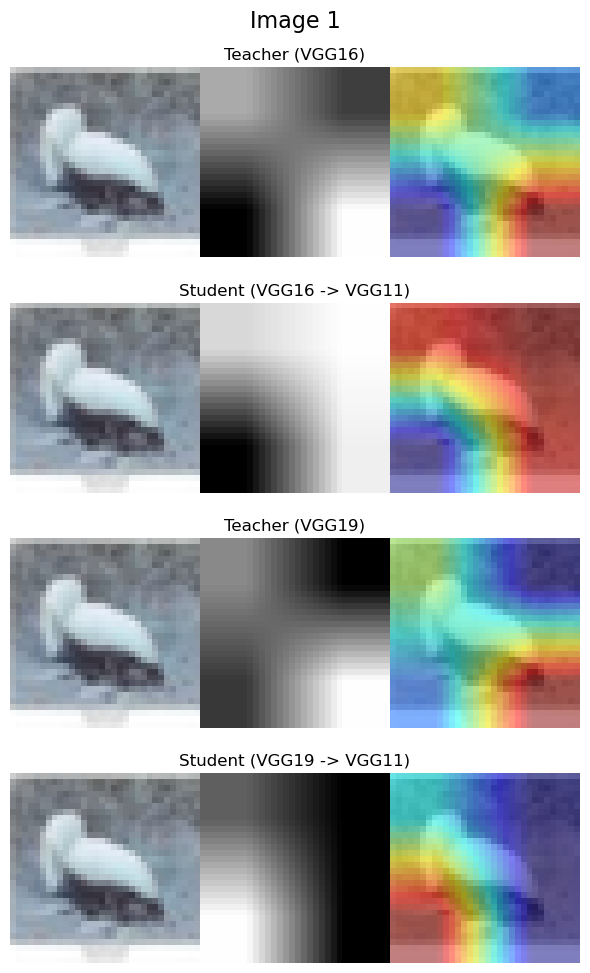

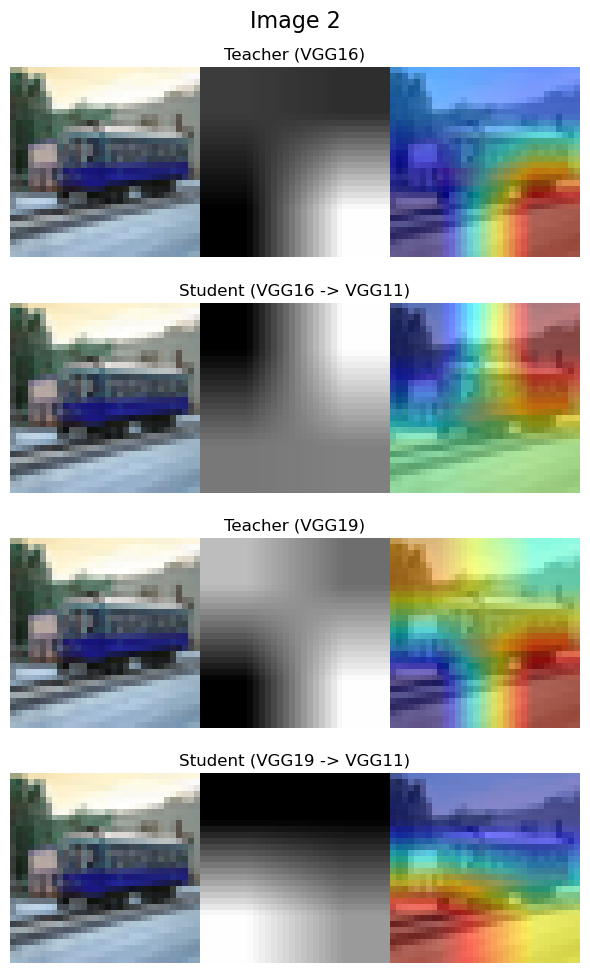

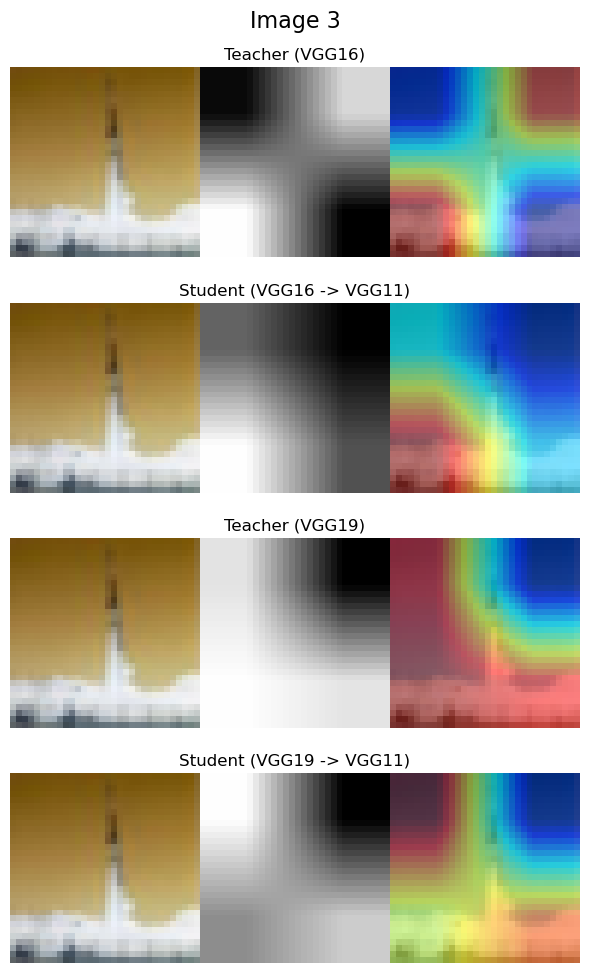

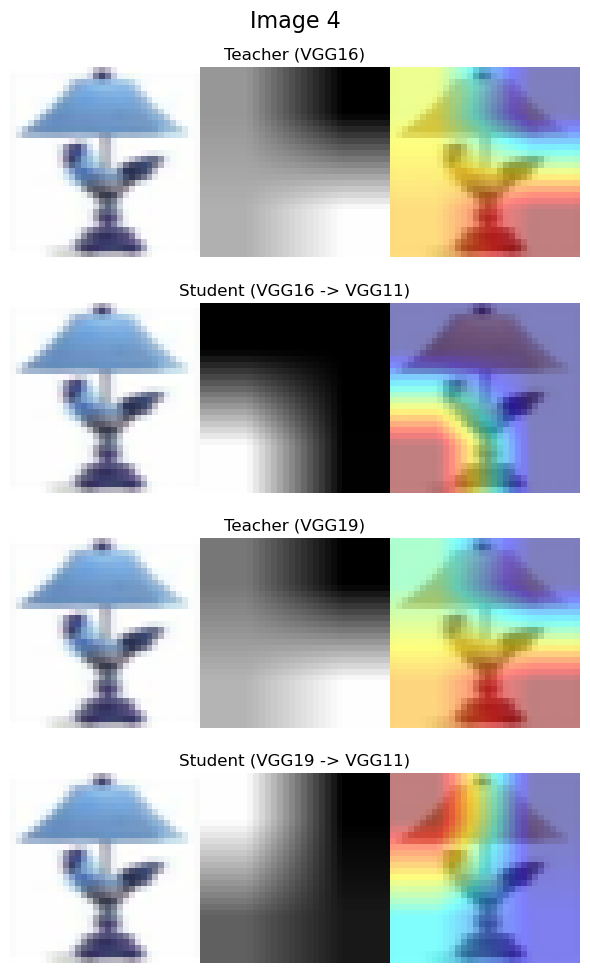

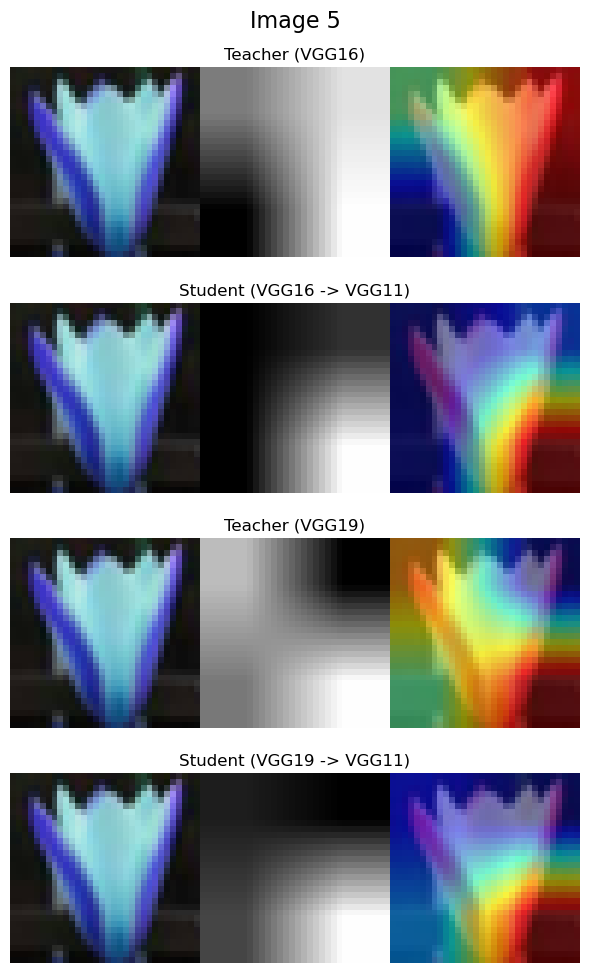

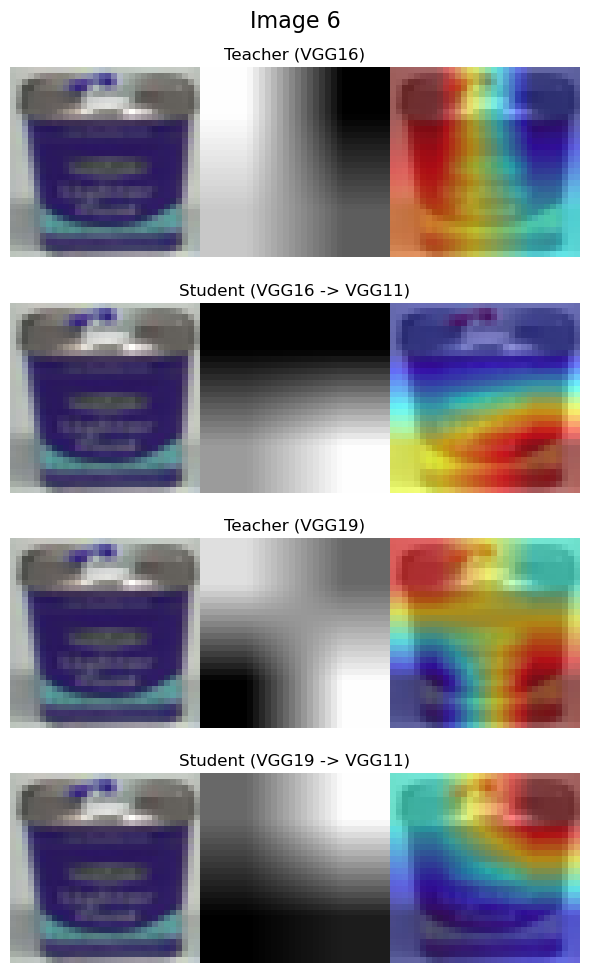

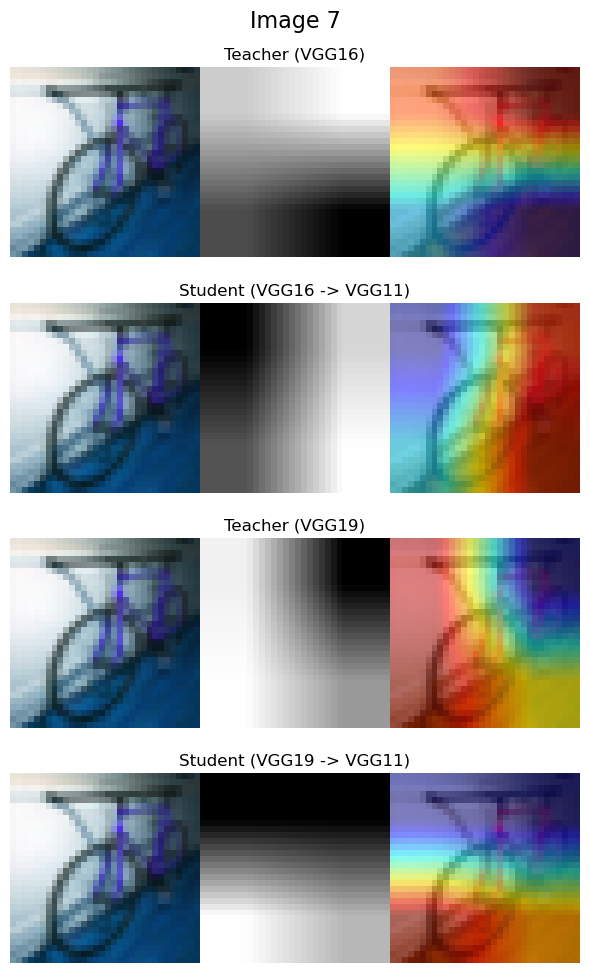

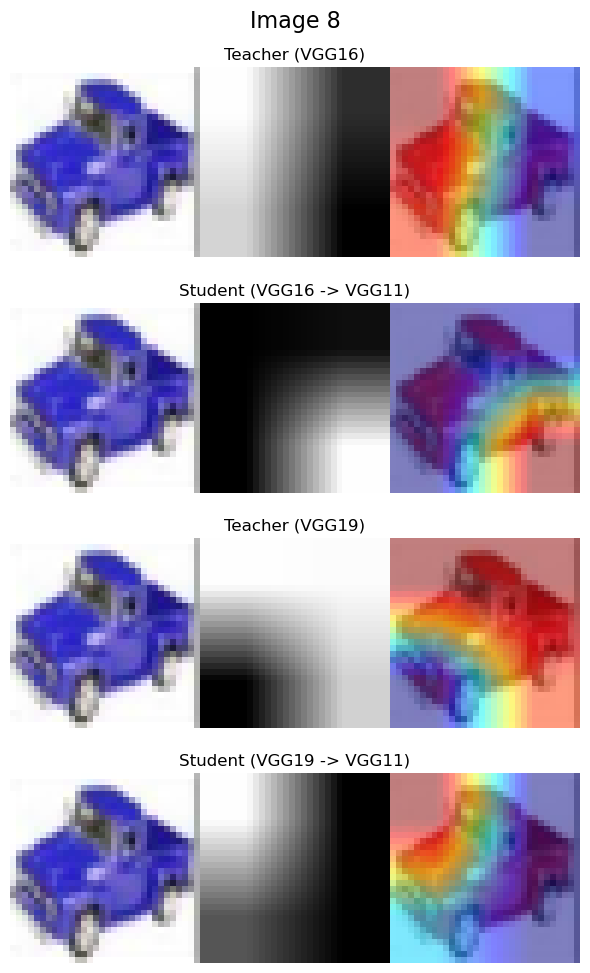

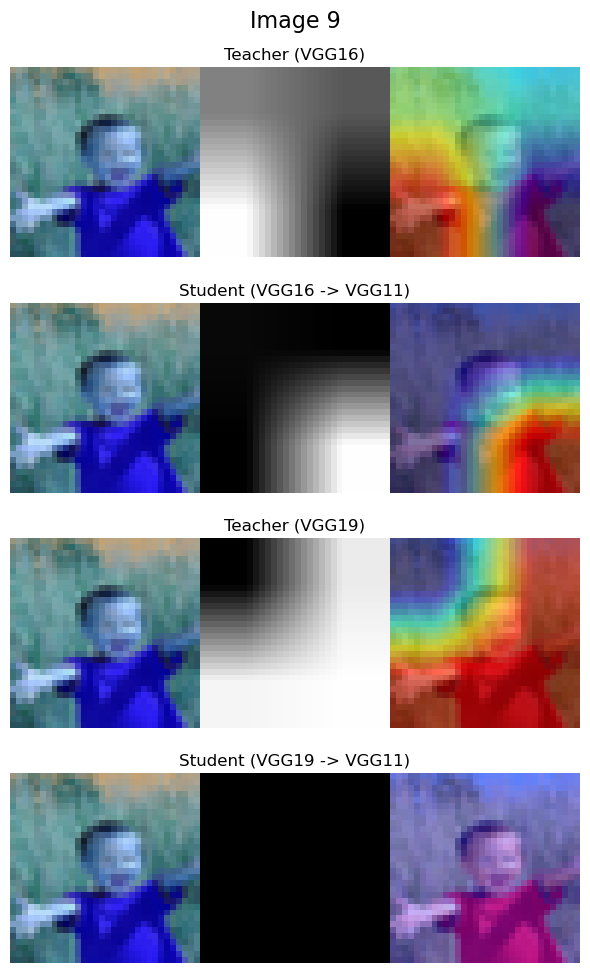

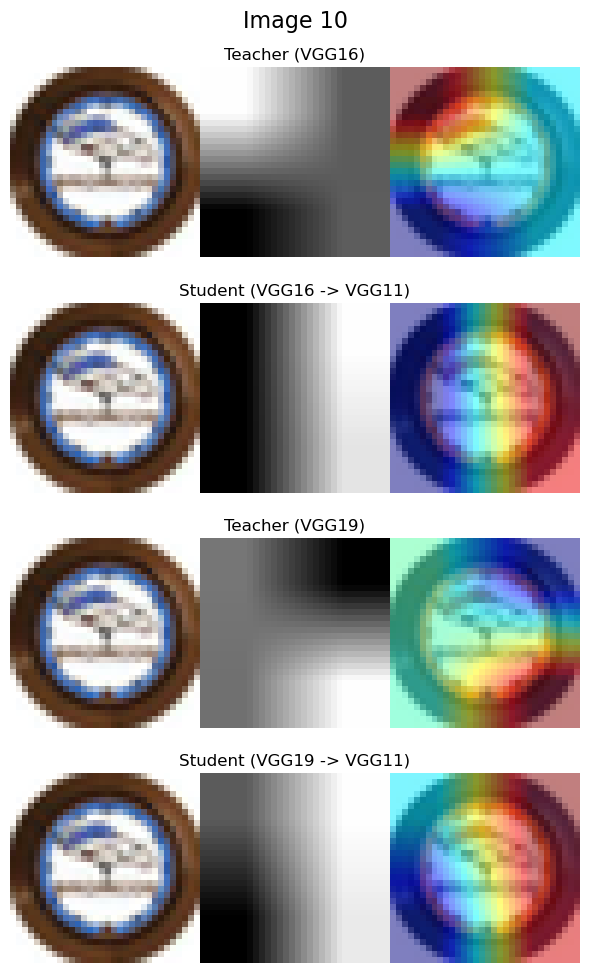

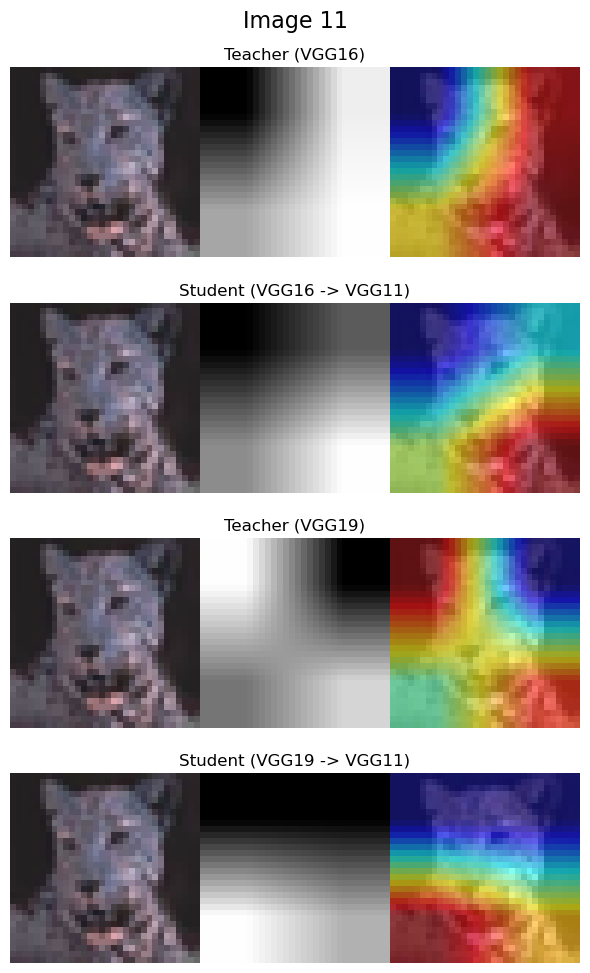

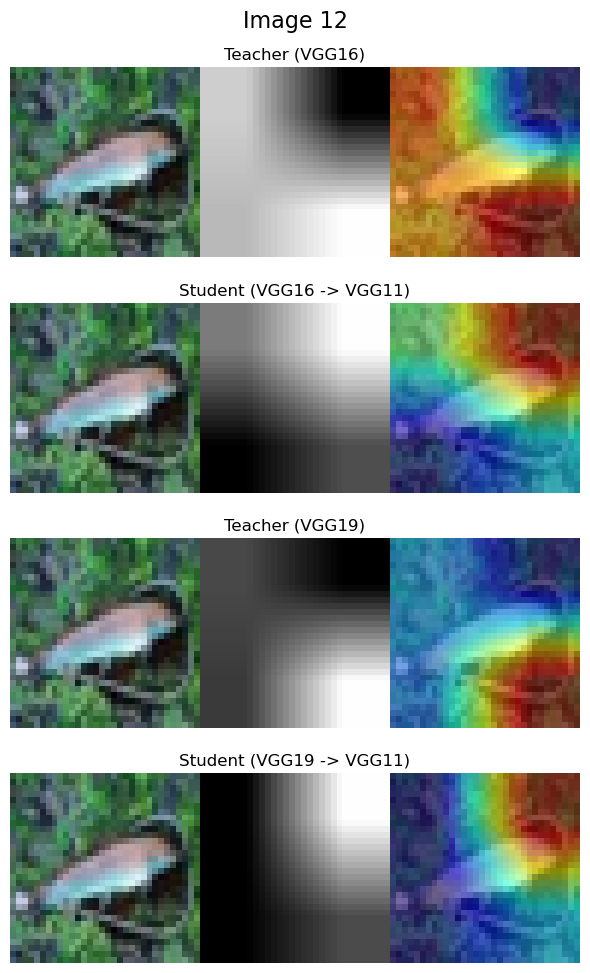

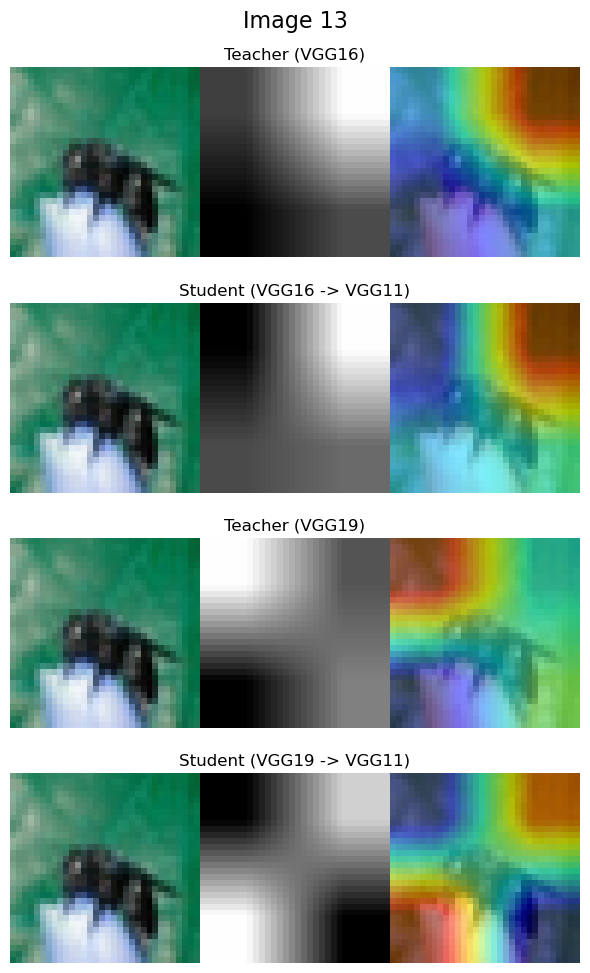

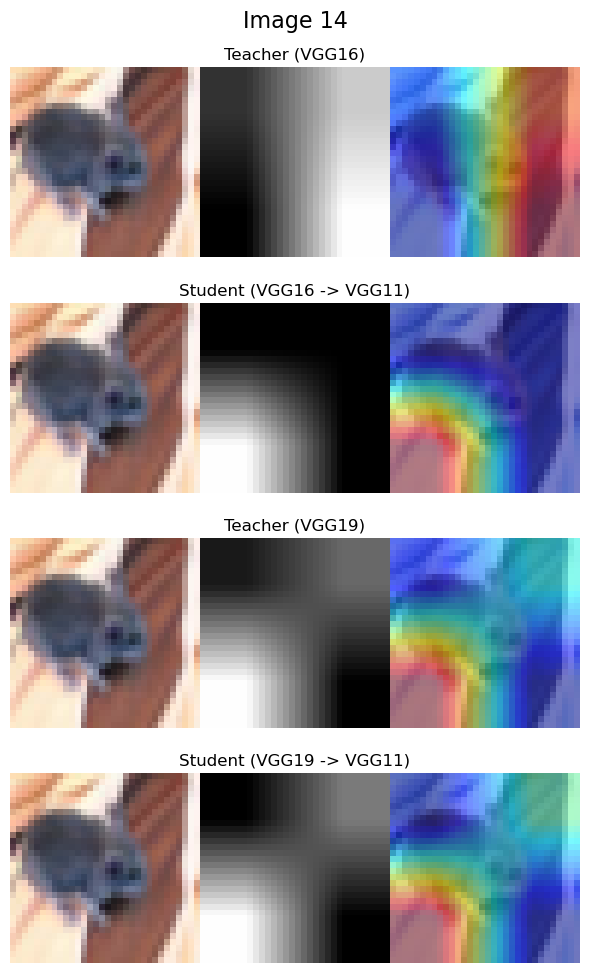

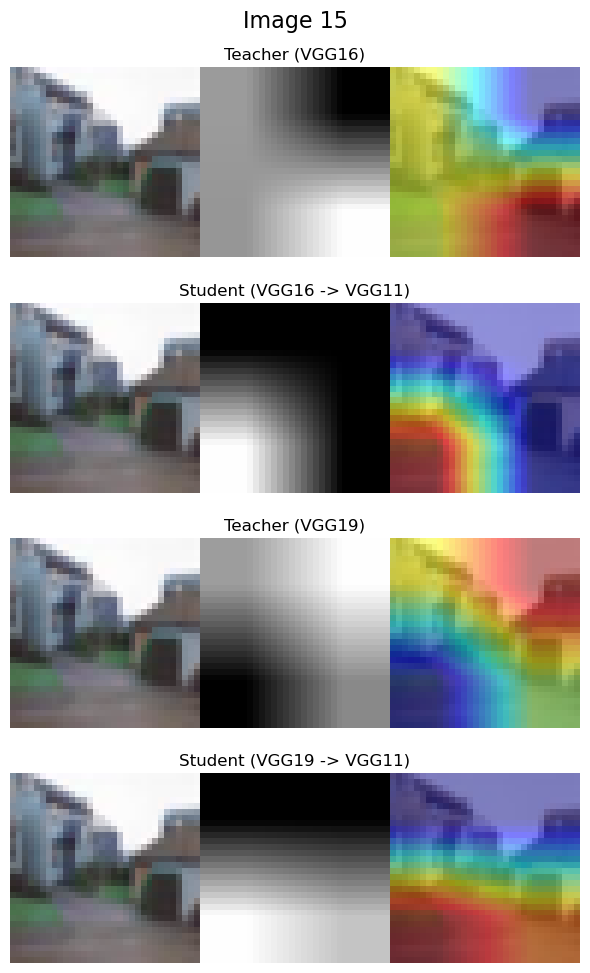

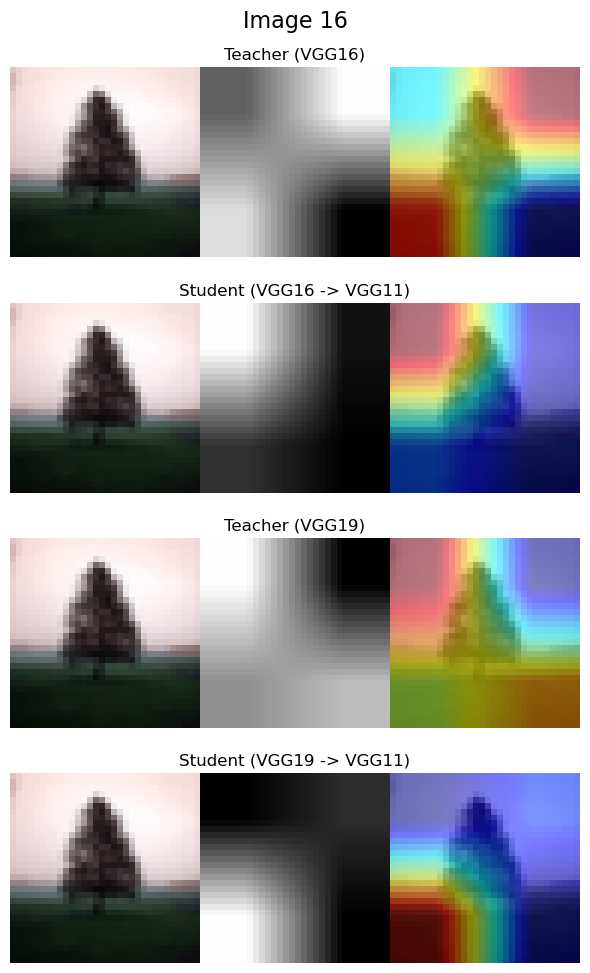

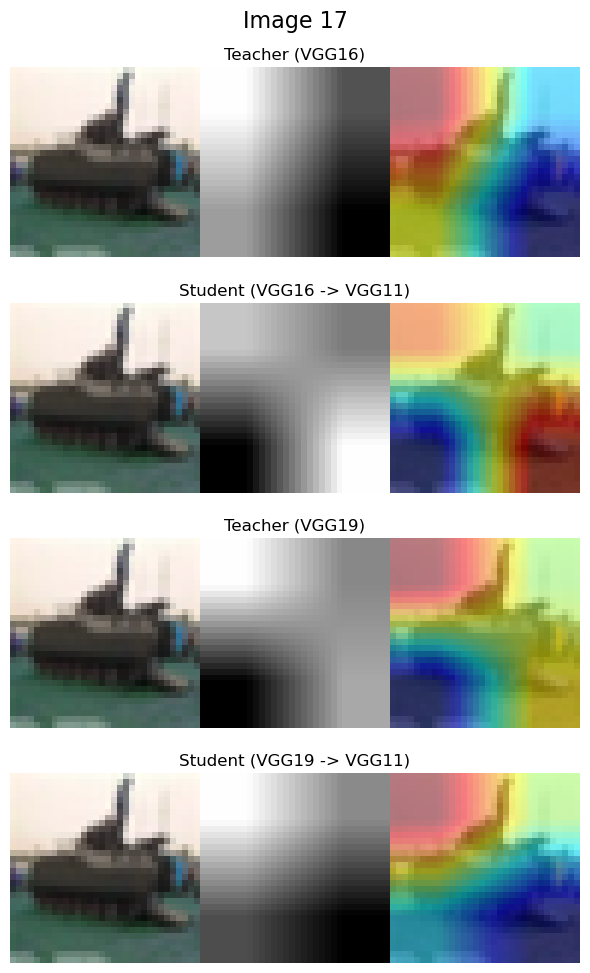

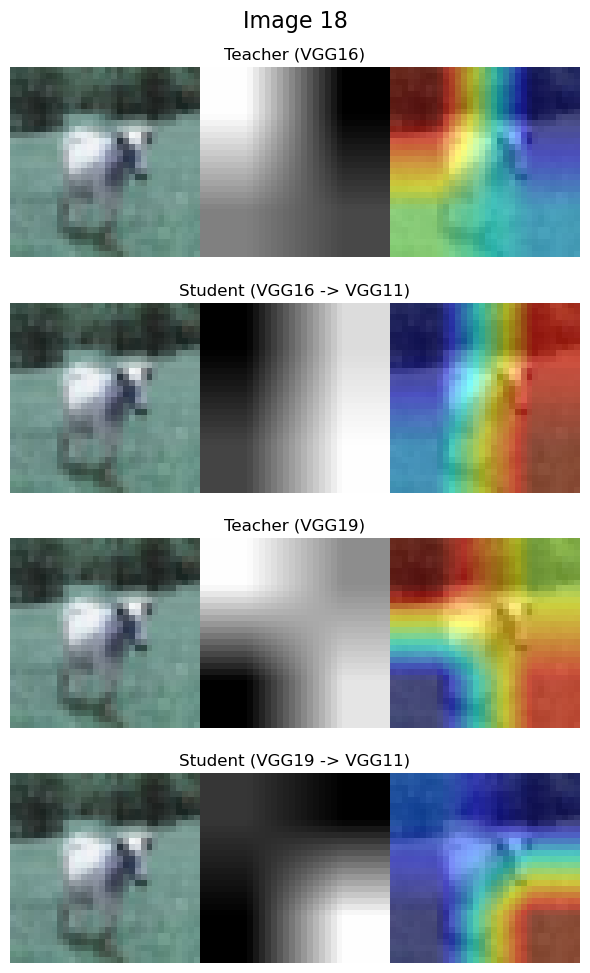

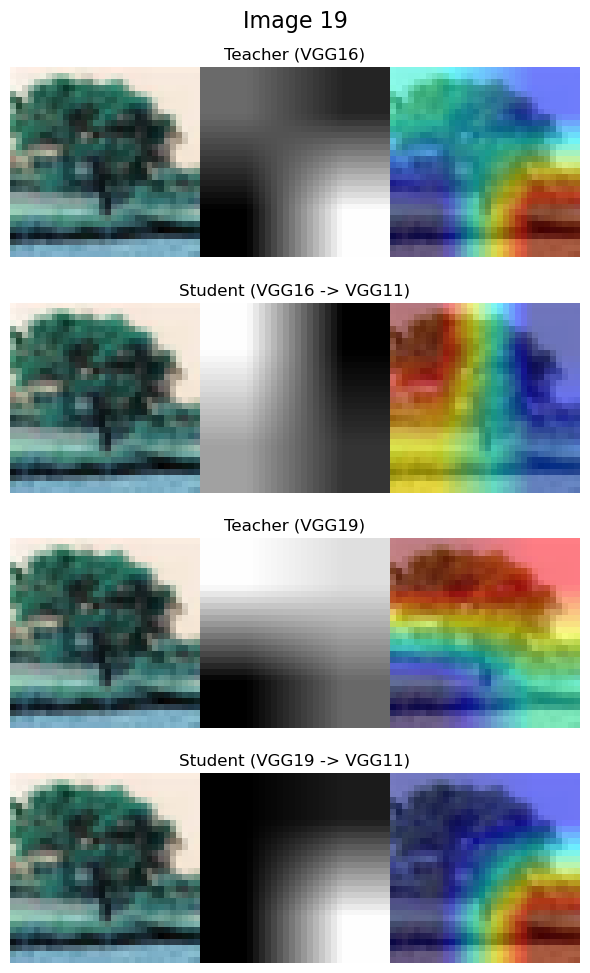

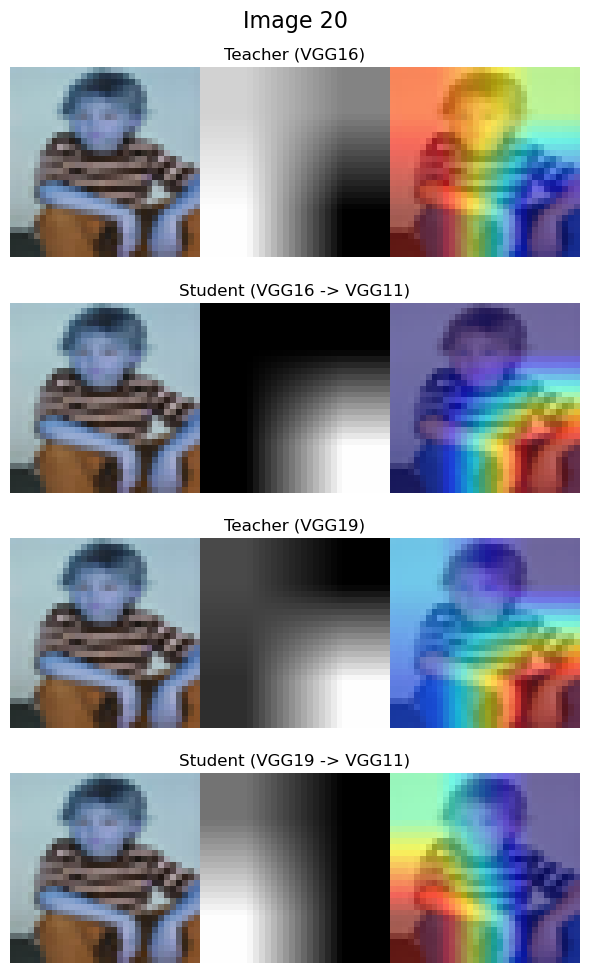

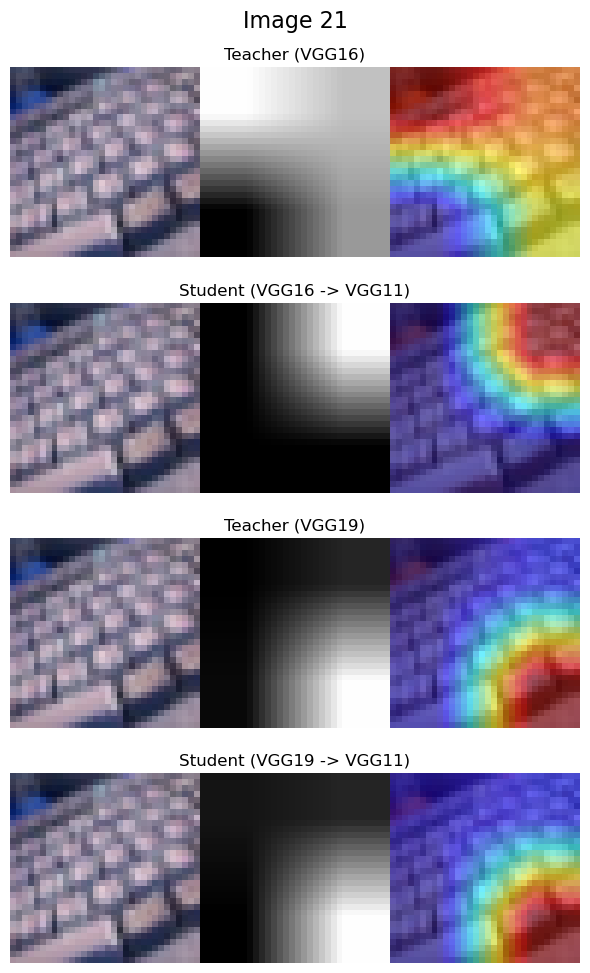

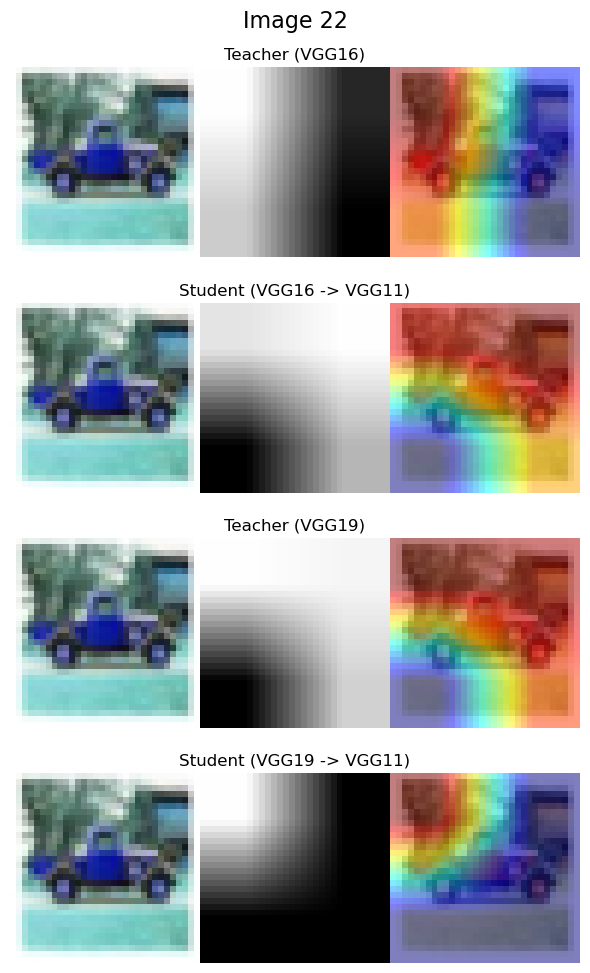

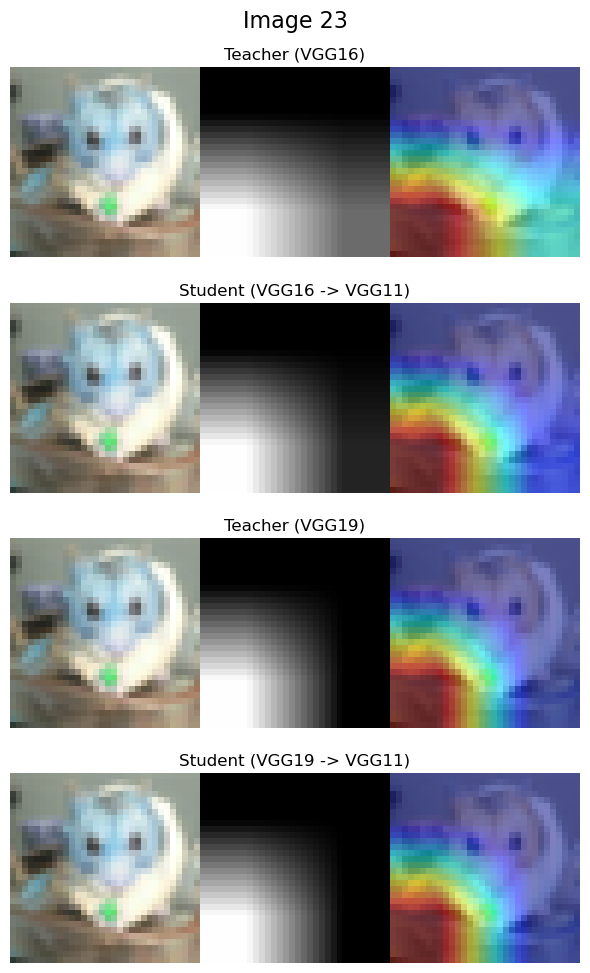

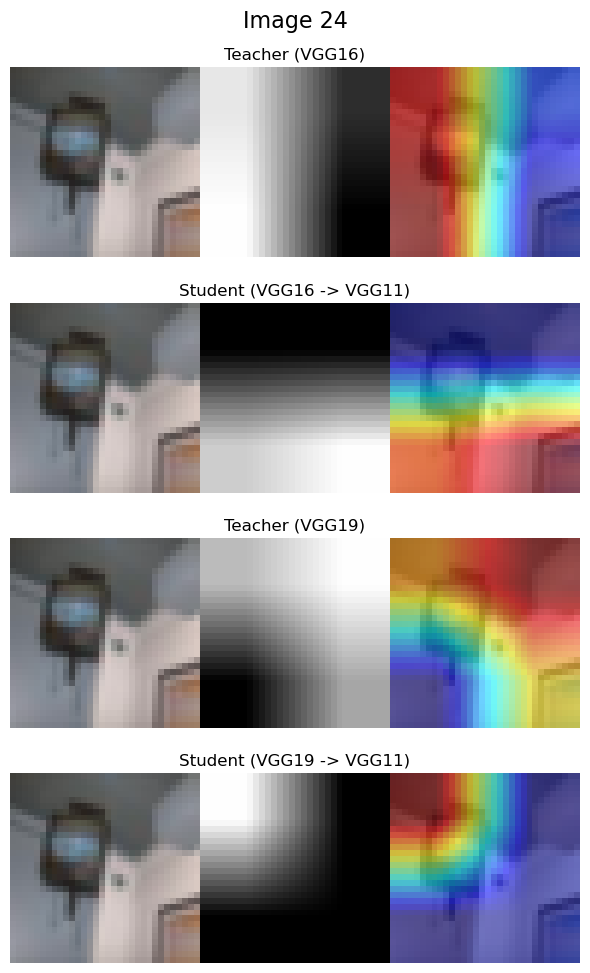

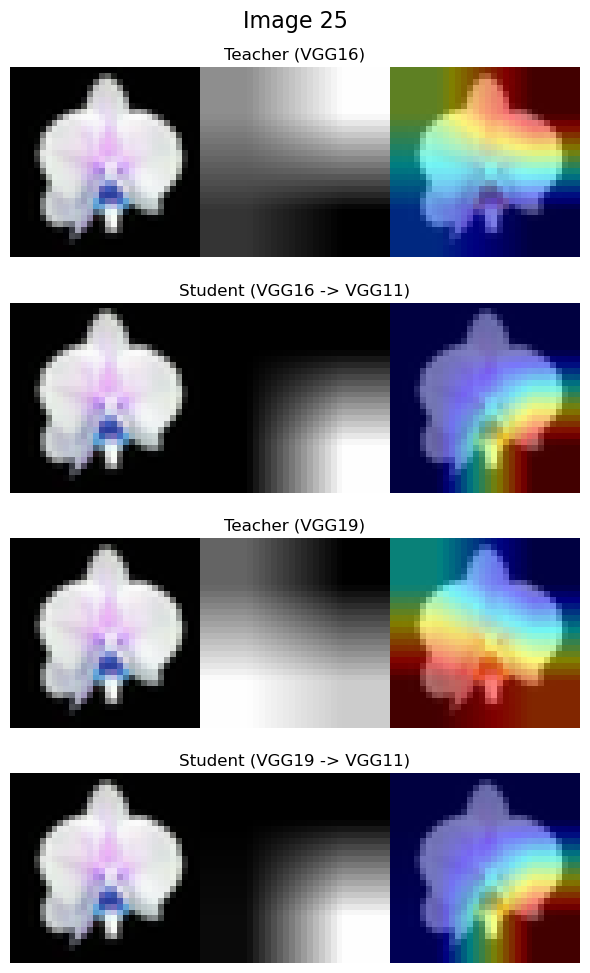

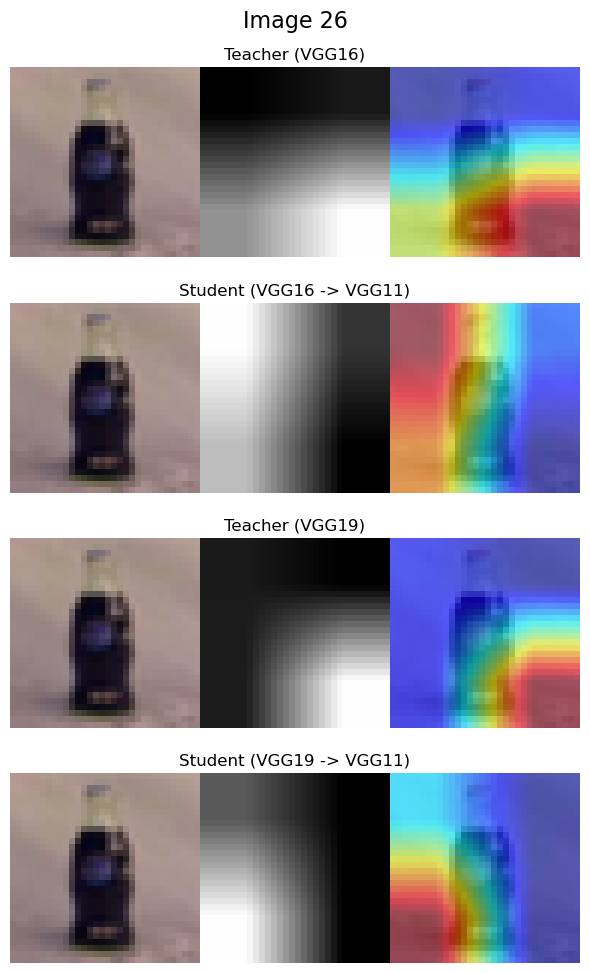

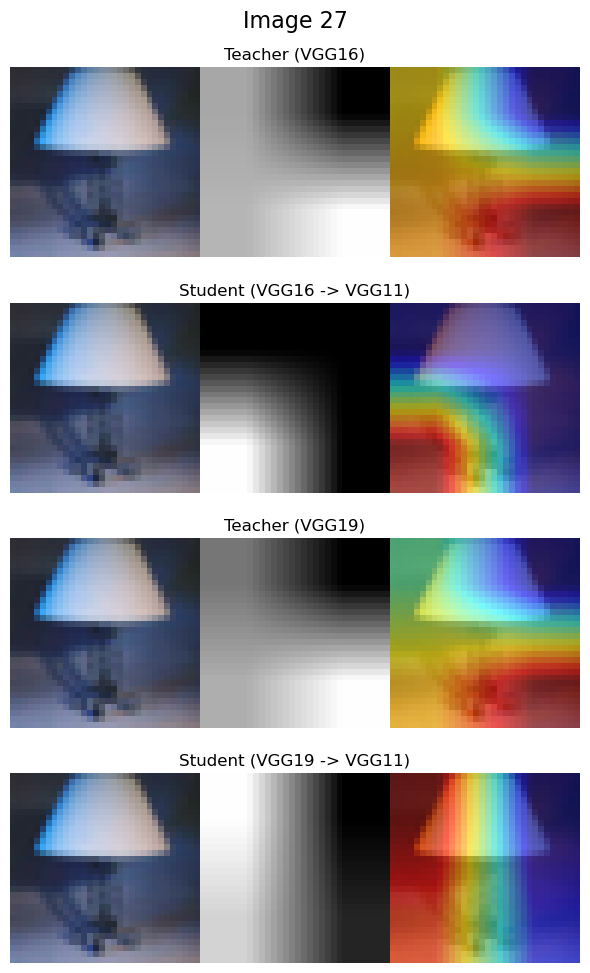

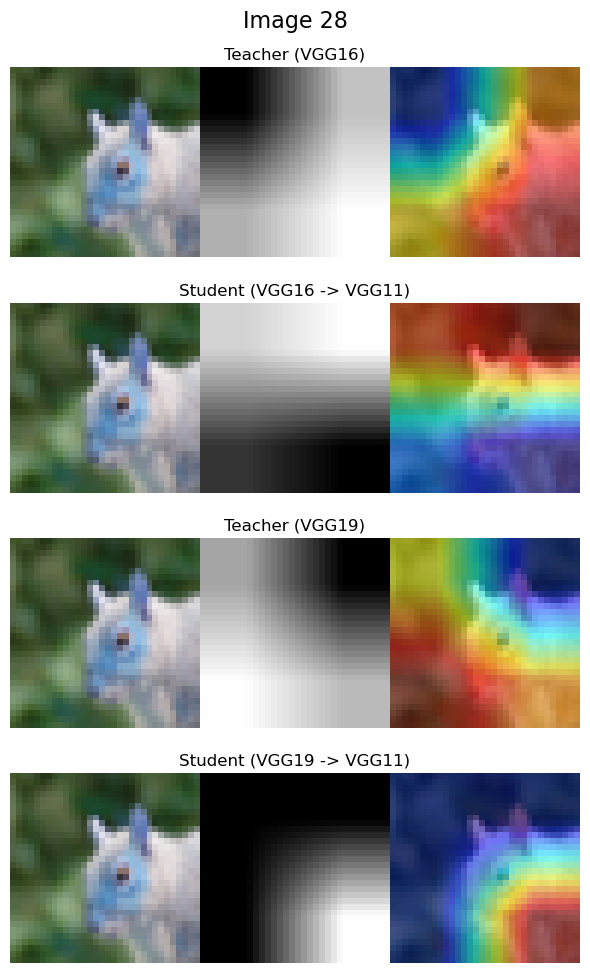

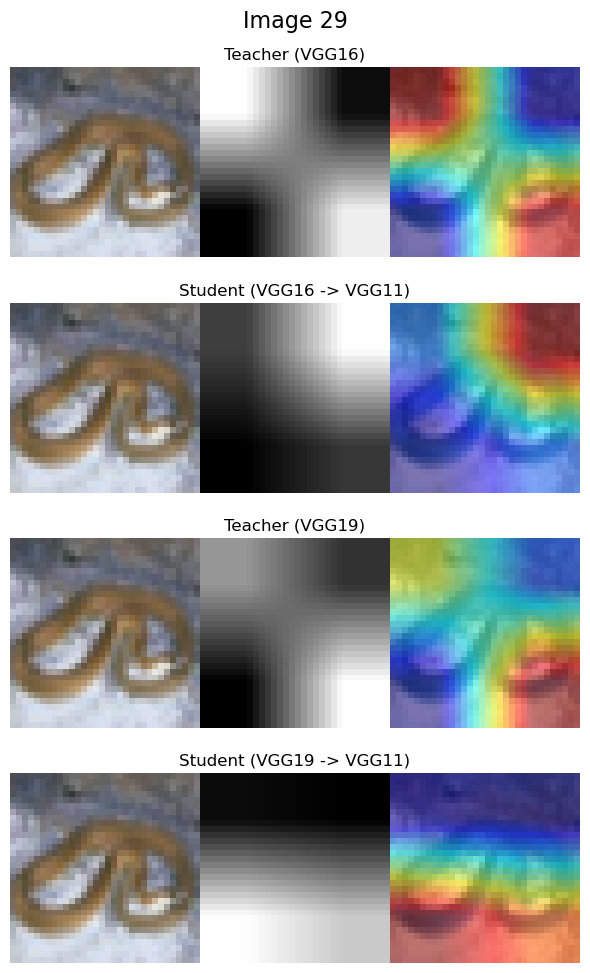

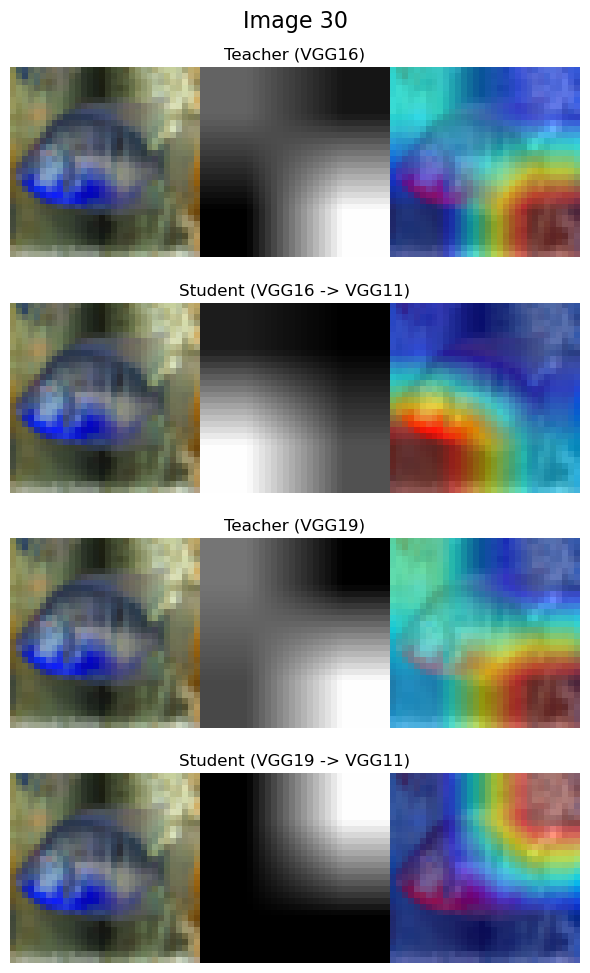

In [46]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have 5 lists of image arrays: s_crd_result, list2, list3, list4, list5
# Each list should have the same number of elements
num_images = len(t_16_result)  # Number of images in each list

# Iterate over each index and create a subplot with 5 rows (one for each list) for each index
for i in range(num_images):
    fig, axes = plt.subplots(4, 1, figsize=(6, 10))  # 5 rows, 1 column for each image set
    fig.suptitle(f"Image {i + 1}", fontsize=16)
    
    # Display each list's image at index i in a subplot row
    axes[0].imshow(t_16_result[i])
    axes[0].set_title('Teacher (VGG16)')
    
    axes[1].imshow(s_16_result[i])
    axes[1].set_title('Student (VGG16 -> VGG11)')
    
    axes[2].imshow(t_19_result[i])
    axes[2].set_title('Teacher (VGG19)')
    
    axes[3].imshow(s_19_result[i])
    axes[3].set_title('Student (VGG19 -> VGG11)')
    
    # Remove axis ticks for clarity
    for ax in axes:
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

In [48]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
def calculate_similarity_percentage(teacher_CAMS, distilled_CAMS):
    # Ensure inputs are numpy arrays for efficient computation
    teacher_CAMS = np.array([np.array(cam).sum(axis=-1).flatten() for cam in teacher_CAMS])
    distilled_CAMS = np.array([np.array(cam).sum(axis=-1).flatten() for cam in distilled_CAMS])

    total_images = len(teacher_CAMS)
    
    print("Average cosine similarity between CAMs: ", np.mean([cosine_similarity([teacher_CAMS[i]], [distilled_CAMS[i]])[0, 0] for i in range(total_images)]))

test = CIFAR100(root='./data', train=False, download=True)
def find_cams(model):
    model.eval()
    for param in model.parameters():
        param.requires_grad = True
    result = []
    for i in range(len(test)):
        image = test[i][0]
        label = test[i][1]
        original_image = np.array(image)
        original_image = np.float32(original_image) / 255
        rgb_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

        input_tensor = transform_test(rgb_image).unsqueeze(0)  # Add batch dimension

        # Choose the target class label
        target_label = label  # Replace with desired class index
        targets = [ClassifierOutputTarget(target_label)]
        target_layer = [model.features[-2]]

        # Initialize Grad-CAM with the model and target layer
        cam = GradCAM(model=model, target_layers=target_layer)

        # Generate the Grad-CAM heatmap
        grayscale_cams = cam(input_tensor=input_tensor, targets=targets)
        cam_image = show_cam_on_image(original_image, grayscale_cams[0, :], use_rgb=True)  # First image in batch
        cam = np.uint8(255*grayscale_cams[0, :])
        cam = cv2.merge([cam, cam, cam])
        result.append(cam)
    return result

t_16_result = find_cams(teacher_model_vgg16_bn)
t_19_result = find_cams(teacher_model_vgg19_bn)
student_model = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar100_vgg11_bn", pretrained=False).to(device)
student_model.load_state_dict(torch.load("vgg11_cifar100_blm_6.pth"))
student_model.eval()
s_16_result = find_cams(student_model)
student_model = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar100_vgg11_bn", pretrained=False).to(device)
student_model.load_state_dict(torch.load("vgg11_cifar100_blm_vgg19.pth"))
student_model.eval()
s_19_result = find_cams(student_model)


teacher_model_vgg16_bn.eval()
print("VGG16 Teacher -> VGG11 Student")
calculate_similarity_percentage(t_16_result, s_16_result)   
print("VGG19 Teacher -> VGG11 Student")
calculate_similarity_percentage(t_19_result, s_19_result)
print("Similarity between VGG16 and VGG19 Teacher")
calculate_similarity_percentage(t_16_result, t_19_result)
print("Similarity between VGG16 and VGG19 Student")
calculate_similarity_percentage(s_16_result, s_19_result)
print("Similarity between VGG16 Teacher and VGG19 Student")
calculate_similarity_percentage(t_16_result, s_19_result)
print("Similarity between VGG19 Teacher and VGG16 Student")
calculate_similarity_percentage(t_19_result, s_16_result)

Files already downloaded and verified


Using cache found in C:\Users\PCF/.cache\torch\hub\chenyaofo_pytorch-cifar-models_master
Using cache found in C:\Users\PCF/.cache\torch\hub\chenyaofo_pytorch-cifar-models_master


VGG16 Teacher -> VGG11 Student
Average cosine similarity between CAMs:  0.5156549368081234
VGG19 Teacher -> VGG11 Student
Average cosine similarity between CAMs:  0.530460820980207
Similarity between VGG16 and VGG19 Teacher
Average cosine similarity between CAMs:  0.646602191034588
Similarity between VGG16 and VGG19 Student
Average cosine similarity between CAMs:  0.4969854314031369
Similarity between VGG16 Teacher and VGG19 Student
Average cosine similarity between CAMs:  0.5331417047300795
Similarity between VGG19 Teacher and VGG16 Student
Average cosine similarity between CAMs:  0.5344427098776889
